# Abalone Rings Classification using Dense Layers

In [56]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt

In [57]:
data = pd.read_csv('data/abalone.csv')
data['Sex'] = data['Sex'].map({'M': 0, 'F': 1, 'I': 2})

X = data.drop('Rings', axis=1).values
y = data['Rings'].values - 1

In [58]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

X_train_tensor = torch.FloatTensor(X_train_scaled)
y_train_tensor = torch.LongTensor(y_train)
X_val_tensor = torch.FloatTensor(X_val_scaled)
y_val_tensor = torch.LongTensor(y_val)
X_test_tensor = torch.FloatTensor(X_test_scaled)
y_test_tensor = torch.LongTensor(y_test)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=True)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)

In [59]:
class AbaloneNet(nn.Module):
    def __init__(self, input_size, num_classes):
        super(AbaloneNet, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.bn1 = nn.BatchNorm1d(64)
        self.fc2 = nn.Linear(64, 32)
        self.bn2 = nn.BatchNorm1d(32)
        self.fc3 = nn.Linear(32, num_classes)
        self.dropout = nn.Dropout(0.3)
        
    def forward(self, x):
        x = torch.relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x = torch.relu(self.bn2(self.fc2(x)))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

In [60]:
input_size = X_train.shape[1]
num_classes = len(np.unique(y)) + 1
net = AbaloneNet(input_size, num_classes)

In [61]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [62]:
num_epochs = 100
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    net.train()
    train_correct = 0
    train_total = 0
    
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = net(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        
        _, predicted = torch.max(outputs.data, 1)
        train_total += batch_y.size(0)
        train_correct += (predicted == batch_y).sum().item()
    
    train_accuracy = train_correct / train_total
    train_accuracies.append(train_accuracy)
    
    net.eval()
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for batch_X, batch_y in val_loader:
            outputs = net(batch_X)
            _, predicted = torch.max(outputs.data, 1)
            val_total += batch_y.size(0)
            val_correct += (predicted == batch_y).sum().item()
    
    val_accuracy = val_correct / val_total
    val_accuracies.append(val_accuracy)
    
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Accuracy: {train_accuracy:.4f}, Validation Accuracy: {val_accuracy:.4f}')

Epoch [10/100], Train Accuracy: 0.2476, Validation Accuracy: 0.2462
Epoch [20/100], Train Accuracy: 0.2630, Validation Accuracy: 0.2444
Epoch [30/100], Train Accuracy: 0.2763, Validation Accuracy: 0.2564
Epoch [40/100], Train Accuracy: 0.2669, Validation Accuracy: 0.2530
Epoch [50/100], Train Accuracy: 0.2712, Validation Accuracy: 0.2598
Epoch [60/100], Train Accuracy: 0.2776, Validation Accuracy: 0.2752
Epoch [70/100], Train Accuracy: 0.2784, Validation Accuracy: 0.2803
Epoch [80/100], Train Accuracy: 0.3007, Validation Accuracy: 0.2598
Epoch [90/100], Train Accuracy: 0.2866, Validation Accuracy: 0.2803
Epoch [100/100], Train Accuracy: 0.2789, Validation Accuracy: 0.2615


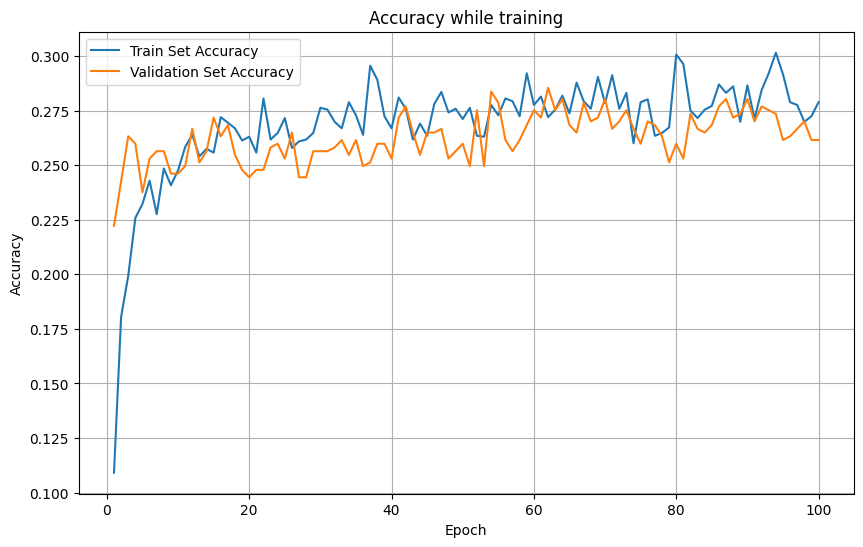

In [63]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Set Accuracy')
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Set Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy while training')
plt.legend()
plt.grid(True)
plt.show()
plt.close()

In [64]:
net.eval()
with torch.no_grad():
    test_outputs = net(X_test_tensor)
    _, predicted = torch.max(test_outputs.data, 1)
    accuracy = accuracy_score(y_test, predicted)
    print(f'Test Accuracy: {accuracy:.4f}')
    print('Classification Report:')
    print(classification_report(y_test, predicted))

Test Accuracy: 0.2919
Classification Report:
              precision    recall  f1-score   support

           2       0.00      0.00      0.00         3
           3       0.39      0.68      0.50        19
           4       0.33      0.02      0.04        45
           5       0.34      0.51      0.41        77
           6       0.41      0.32      0.36       129
           7       0.36      0.41      0.38       164
           8       0.32      0.43      0.36       212
           9       0.24      0.34      0.28       191
          10       0.23      0.27      0.25       137
          11       0.00      0.00      0.00        84
          12       0.10      0.11      0.11        53
          13       0.00      0.00      0.00        34
          14       0.21      0.13      0.16        31
          15       0.12      0.10      0.11        21
          16       0.00      0.00      0.00        14
          17       0.00      0.00      0.00        15
          18       0.00      0.00   

/Users/measaverb/miniconda3/envs/ai-class/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/measaverb/miniconda3/envs/ai-class/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/measaverb/miniconda3/envs/ai-class/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier